<a href="https://colab.research.google.com/github/SajlaKM/XGBoost/blob/main/XGBoost_NASA_SoH_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [2]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
import zipfile
import scipy.io as sio
import numpy as np
import pandas as pd
import os

In [ ]:
Data of Battery Number 5(B0005)

SyntaxError: invalid syntax (ipython-input-2404424443.py, line 1)

In [4]:
from scipy.io import loadmat

data1 = loadmat('B0005.mat')
battery_data1 = data1['B0005'][0][0]['cycle'][0]

Total number of cycles in B0005: 616
Charge cycles: 170, Discharge cycles: 168
Capacity for this cycle: 1.8565 Ah
Number of data points: 197


,Time (s),Voltage (V),Current (A),Temperature (°C)
0,0.000,4.191492,-0.004902,24.330034
1,16.781,4.190749,-0.001478,24.325993
2,35.703,3.974871,-2.012528,24.389085
3,53.781,3.951717,-2.013979,24.544752
4,71.922,3.934352,-2.011144,24.731385


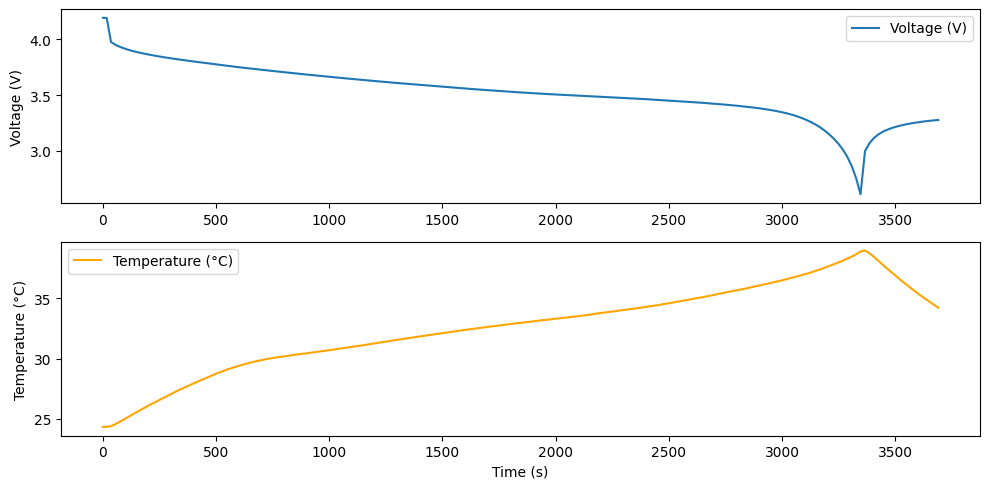

In [7]:
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt

data = sio.loadmat("B0005.mat")
battery = data["B0005"][0][0]
cycles = battery["cycle"][0]

print(f"Total number of cycles in B0005: {len(cycles)}")

charge_cycles = []
discharge_cycles = []

for c in cycles:
    ctype = c["type"][0]
    if ctype == "charge":
        charge_cycles.append(c)
    elif ctype == "discharge":
        discharge_cycles.append(c)

print(f"Charge cycles: {len(charge_cycles)}, Discharge cycles: {len(discharge_cycles)}")

sample_cycle = discharge_cycles[0]
d = sample_cycle["data"][0][0]

time = d["Time"][0]
voltage = d["Voltage_measured"][0]
current = d["Current_measured"][0]
temperature = d["Temperature_measured"][0]
capacity = d["Capacity"][0][0]  # scalar value

print(f"Capacity for this cycle: {capacity:.4f} Ah")
print(f"Number of data points: {len(time)}")

df = pd.DataFrame({
    "Time (s)": time,
    "Voltage (V)": voltage,
    "Current (A)": current,
    "Temperature (°C)": temperature
})
display(df.head())

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(time, voltage, label="Voltage (V)")
plt.ylabel("Voltage (V)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(time, temperature, color='orange', label="Temperature (°C)")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
charging_curves, discharging_curves = [], []

for c in battery_data1:
    if c['type'][0] == 'charge':
        charging_curves.append({
            'voltage': c['data'][0][0]['Voltage_measured'][0],
            'current': c['data'][0][0]['Current_measured'][0],
            'temperature': c['data'][0][0]['Temperature_measured'][0],
            'time': c['data'][0][0]['Time'][0],
        })
    elif c['type'][0] == 'discharge':
        discharging_curves.append({
            'voltage': c['data'][0][0]['Voltage_measured'][0],
            'current': c['data'][0][0]['Current_measured'][0],
            'temperature': c['data'][0][0]['Temperature_measured'][0],
            'capacity': c['data'][0][0]['Capacity'][0][0],
            'time': c['data'][0][0]['Time'][0],
        })

In [ ]:
IHIs of B0005

In [10]:
def extract_IHIs(curve):
    V, I, T, time = curve['voltage'], curve['current'], curve['temperature'], curve['time']
    return [
        V[-1] - V[0],                 # ΔVoltage
        np.trapz(I, time),            # Area under current curve
        np.mean(T),                   # Mean temperature
        np.max(T) - np.min(T),        # ΔTemperature
        time[-1] - time[0]            # Total duration
    ]

charging_IHIs1 = [extract_IHIs(c) for c in charging_curves]
discharging_IHIs1 = [extract_IHIs(c) for c in discharging_curves]

/tmp/ipython-input-3193166861.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(I, time),            # Area under current curve


In [ ]:
PCA of B0005

In [11]:
pca_chg1 = PCA(n_components=1).fit_transform(charging_IHIs1)
pca_dis1 = PCA(n_components=1).fit_transform(discharging_IHIs1)

In [ ]:
Feature set of B0005

In [12]:
capacities = np.array([c['capacity'] for c in discharging_curves])
SoH = capacities / capacities[0]

# time difference between cycles
time_diff = np.diff([c['time'][-1] for c in discharging_curves], prepend=0)

# final feature set
X = np.column_stack((pca_chg1[:len(SoH)], pca_dis1[:len(SoH)], time_diff))
y = SoH

In [ ]:
n_steps = 300  # sequence length

In [ ]:
XGBoost Training for B0005

In [13]:
split = 50
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
True SoH plot for B0005

RMSE: 0.0854990322231646


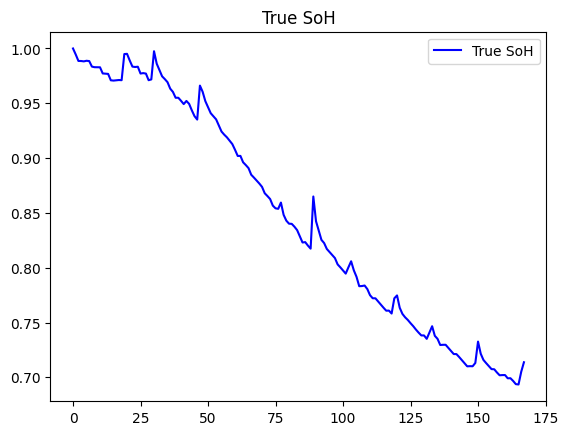

In [14]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test[:50], y_pred[:50]))
print("RMSE:", rmse)

plt.plot(y, label='True SoH', color='blue')
plt.legend(); plt.title("True SoH"); plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)


MAE: 0.14723769135015408


In [ ]:
Predicted SoH plot for B0018

RMSE: 0.0854990322231646


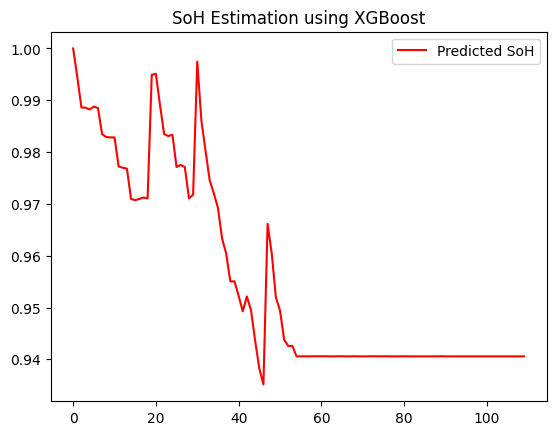

In [18]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test[:50], y_pred[:50]))
print("RMSE:", rmse)


plt.plot(np.concatenate([y_train[:60], y_pred[:60]]), label='Predicted SoH', color='red')
plt.legend(); plt.title("SoH Estimation using XGBoost"); plt.show()

In [ ]:
Combined plot of True and Predicted SoH for B0005

RMSE: 0.0854990322231646


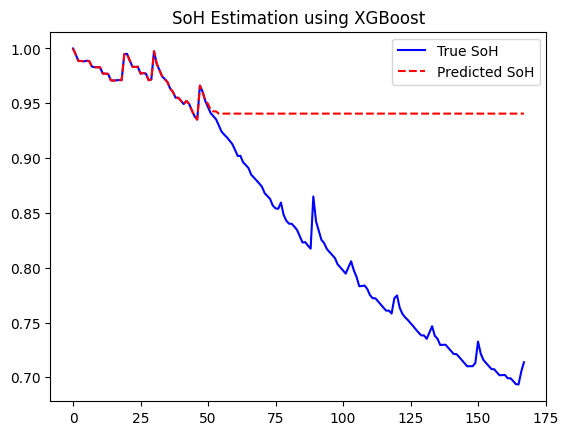

In [19]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test[:50], y_pred[:50]))
print("RMSE:", rmse)

plt.plot(y, label='True SoH', color='blue')
plt.plot(np.concatenate([y_train, y_pred]),linestyle='--', label='Predicted SoH', color='red')
plt.legend(); plt.title("SoH Estimation using XGBoost"); plt.show()

In [ ]:
Data of Battery Number 5(B0018)

In [20]:
from scipy.io import loadmat

data2 = loadmat('B0018.mat')
battery_data2 = data2['B0018'][0][0]['cycle'][0]


Total number of cycles in B0007: 319
Charge cycles: 134, Discharge cycles: 132
Capacity for this cycle: 1.8550 Ah
Number of data points: 366


,Time (s),Voltage (V),Current (A),Temperature (°C)
0,0.000,4.188109,0.000131,23.819520
1,9.422,4.188196,0.001459,23.828807
2,19.578,3.977432,-2.005672,23.844944
3,29.016,3.961974,-2.012206,23.925577
4,38.485,3.949835,-2.012005,24.010628


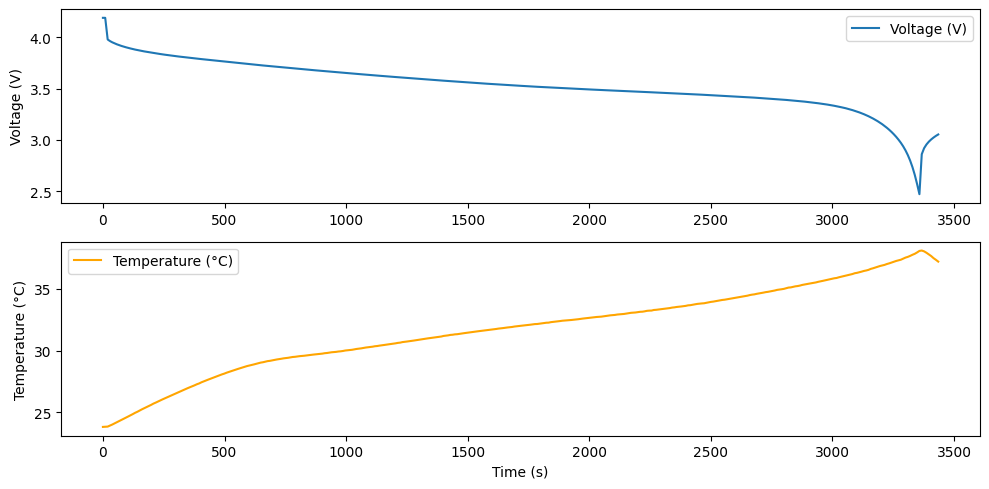

In [21]:
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt

Data = sio.loadmat("B0018.mat")
battery = Data["B0018"][0][0]
cycles = battery["cycle"][0]

print(f"Total number of cycles in B0007: {len(cycles)}")

charge_cycles = []
discharge_cycles = []

for c in cycles:
    ctype = c["type"][0]
    if ctype == "charge":
        charge_cycles.append(c)
    elif ctype == "discharge":
        discharge_cycles.append(c)

print(f"Charge cycles: {len(charge_cycles)}, Discharge cycles: {len(discharge_cycles)}")

sample_cycle = discharge_cycles[0]
d = sample_cycle["data"][0][0]

time = d["Time"][0]
voltage = d["Voltage_measured"][0]
current = d["Current_measured"][0]
temperature = d["Temperature_measured"][0]
capacity = d["Capacity"][0][0]  # scalar value

print(f"Capacity for this cycle: {capacity:.4f} Ah")
print(f"Number of data points: {len(time)}")

df = pd.DataFrame({
    "Time (s)": time,
    "Voltage (V)": voltage,
    "Current (A)": current,
    "Temperature (°C)": temperature
})
display(df.head())

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(time, voltage, label="Voltage (V)")
plt.ylabel("Voltage (V)")
plt.legend()

plt.subplot(2,1,2)
plt.plot(time, temperature, color='orange', label="Temperature (°C)")
plt.xlabel("Time (s)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
Parameters of B0018

SyntaxError: invalid syntax (ipython-input-668019326.py, line 1)

In [22]:
charging_curves, discharging_curves = [], []

for c in battery_data2:
    if c['type'][0] == 'charge':
        charging_curves.append({
            'voltage': c['data'][0][0]['Voltage_measured'][0],
            'current': c['data'][0][0]['Current_measured'][0],
            'temperature': c['data'][0][0]['Temperature_measured'][0],
            'time': c['data'][0][0]['Time'][0],
        })
    elif c['type'][0] == 'discharge':
        discharging_curves.append({
            'voltage': c['data'][0][0]['Voltage_measured'][0],
            'current': c['data'][0][0]['Current_measured'][0],
            'temperature': c['data'][0][0]['Temperature_measured'][0],
            'capacity': c['data'][0][0]['Capacity'][0][0],
            'time': c['data'][0][0]['Time'][0],
        })


In [ ]:
IHIs of B0018

In [23]:
def extract_IHIs(curve):
    V, I, T, time = curve['voltage'], curve['current'], curve['temperature'], curve['time']
    return [
        V[-1] - V[0],                 # ΔVoltage
        np.trapz(I, time),            # Area under current curve
        np.mean(T),                   # Mean temperature
        np.max(T) - np.min(T),        # ΔTemperature
        time[-1] - time[0]            # Total duration
    ]

charging_IHIs2 = [extract_IHIs(c) for c in charging_curves]
discharging_IHIs2 = [extract_IHIs(c) for c in discharging_curves]


/tmp/ipython-input-1560617001.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  np.trapz(I, time),            # Area under current curve


In [ ]:
PCA of B0018

In [24]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Convert list to array if not already
charging_IHIs2 = np.array(charging_IHIs2, dtype=np.float64)
discharging_IHIs2 = np.array(discharging_IHIs2, dtype=np.float64)

# Handle NaNs: Replace with column mean
imputer = SimpleImputer(strategy='mean')
charging_IHIs_clean = imputer.fit_transform(charging_IHIs2)
discharging_IHIs_clean = imputer.fit_transform(discharging_IHIs2)

# Now apply PCA
pca_chg2 = PCA(n_components=1).fit_transform(charging_IHIs_clean)
pca_dis2 = PCA(n_components=1).fit_transform(discharging_IHIs_clean)


In [25]:
capacities = np.array([c['capacity'] for c in discharging_curves])
SoH = capacities / capacities[0]

# time difference between cycles
time_diff = np.diff([c['time'][-1] for c in discharging_curves], prepend=0)

# final feature set
X = np.column_stack((pca_chg2[:len(SoH)], pca_dis2[:len(SoH)], time_diff))
y = SoH


In [ ]:
XGBoost for B0018

In [27]:
split = int(0.7* len(X))
print(split)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(y_train)

model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4)
model.fit(X_train, y_train)

92
[1.         0.99363398 0.99169669 0.98688364 0.98797614 0.98572745
 0.98177722 0.97852592 0.97266504 0.98280096 0.9768846  0.97287722
 0.96541239 0.9614374  0.96007238 0.95482734 0.95343724 0.94535105
 0.94135606 0.9367442  0.93342989 0.92107322 0.92262307 0.92048408
 0.94298326 0.93410539 0.92842433 0.92282594 0.91604512 0.91322508
 0.90668389 0.90402856 0.89785384 0.89336303 0.88852838 0.88343189
 0.87743651 0.87447426 0.87008233 0.90352967 0.88910869 0.87998869
 0.87138115 0.86840912 0.86008624 0.93083732 0.925371   0.91418837
 0.9044605  0.89523161 0.89833254 0.88777876 0.8764205  0.86908561
 0.86562413 0.90223247 0.8843293  0.8696827  0.85827092 0.85530853
 0.85179127 0.84321805 0.83860619 0.83029691 0.82596095 0.82567089
 0.82062312 0.8121418  0.80938992 0.80665756 0.82664284 0.82147793
 0.80926601 0.80453587 0.79963355 0.79823939 0.79434188 0.79138313
 0.7860317  0.78051891 0.78316838 0.77764535 0.7758856  0.77015854
 0.76813973 0.7923493  0.78306115 0.7778063  0.77001217 0.7

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

RMSE: 0.021271869378116006
MAE : 0.017638654244358305


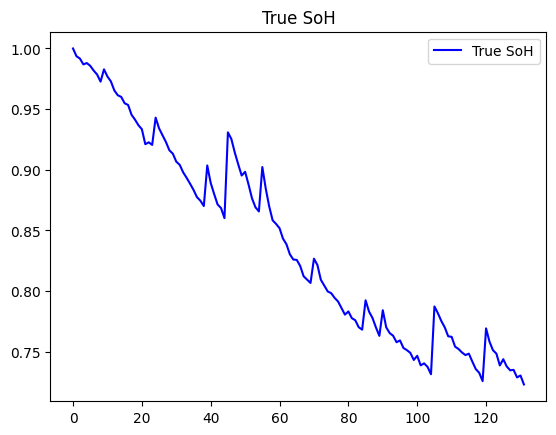

In [29]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print("RMSE:", rmse)
print("MAE :", mae)

plt.plot(y, label='True SoH', color='blue')
plt.legend(); plt.title("True SoH"); plt.show()

RMSE: 0.021271869378116006


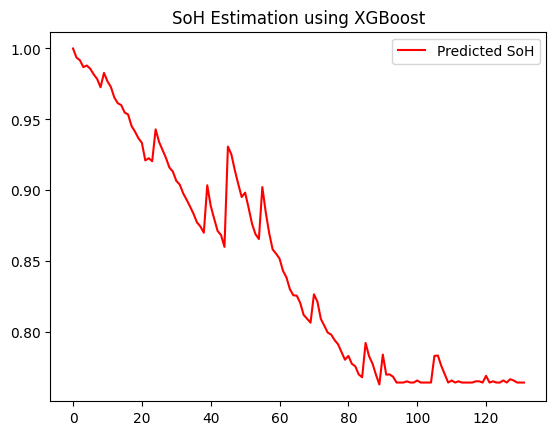

In [30]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


plt.plot(np.concatenate([y_train, y_pred]), label='Predicted SoH', color='red')
plt.legend(); plt.title("SoH Estimation using XGBoost"); plt.show()


RMSE: 0.021271869378116006


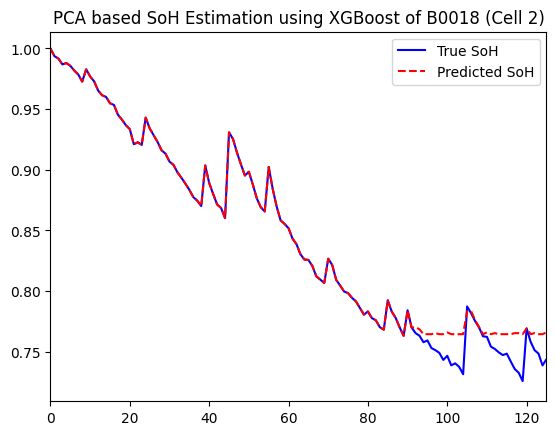

In [31]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
plt.xlim(0, 125)
plt.plot(y, label='True SoH', color='blue')
plt.plot(np.concatenate([y_train, y_pred]),linestyle='--', label='Predicted SoH', color='red')
plt.legend(); plt.title("PCA based SoH Estimation using XGBoost of B0018 (Cell 2)"); plt.show()


In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

In [33]:
kernel = (
    C(1.0, (1e-3, 1e3)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) +
    WhiteKernel(noise_level=1e-5)
)

gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=10
)


In [34]:
gpr.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05),
                         n_restarts_optimizer=10, normalize_y=True)

In [35]:
y_pred, y_std = gpr.predict(X_test, return_std=True)

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [37]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE :", mae)
print("RMSE:", rmse)

MAE : 0.09881007292943492
RMSE: 0.10920043500662181


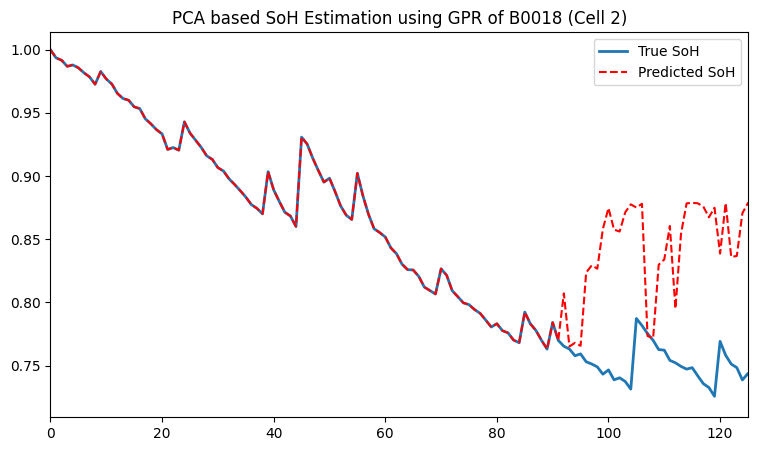

In [38]:

plt.figure(figsize=(9,5))
plt.xlim(0, 125)
plt.plot(y, label="True SoH", linewidth=2)
plt.plot(np.concatenate([y_train, y_pred]),linestyle='--', label='Predicted SoH', color='red')
plt.legend(); plt.title("PCA based SoH Estimation using GPR of B0018 (Cell 2)"); plt.show()
#plt.plot(y_pred, '--', label="GPR Predicted SoH", linewidth=2)

